In [1]:
import os
from time import time
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [2]:
start_time = time()

In [3]:
consider_distort = False
zoomed_coords = True
center_only = True
num_shots = 4
SCALE_FAC = 4.0 # Scale factor of coordinates

In [4]:
img_folder = "data/stars/2016nov-11//" # images folder
res_folder = 'results/2016nov-11//' # results folder
coords_folder = 'data/star_coords/2016nov-11_txt/' # folder with coords files

In [5]:
fnames = [
    "20161122-191517-359.txt",
    "20161122-201517-375.txt",
    "20161122-211517-375.txt",
    "20161122-221517-375.txt"
]

In [6]:
date = fnames[0][:-4]

In [7]:
# for ipynb
fname_left = img_folder + os.sep + "mod_" + date + '-1.jpg'
fname_right = img_folder + os.sep + "mod_" + date + '-2.jpg'

# for cmd line run
# fname_left = os.path.abspath(sys.argv[0])
# fname_right = os.path.abspath(sys.argv[1])

In [8]:
img_left = Image.open(fname_left).convert(mode='RGB')
img_right = Image.open(fname_right).convert(mode='RGB')
print """Images loaded as RGB:
%s
%s""" % (fname_left, fname_right)

Images loaded as RGB:
data/stars/2016nov-11///mod_20161122-191517-359-1.jpg
data/stars/2016nov-11///mod_20161122-191517-359-2.jpg


In [9]:
assert (img_left.size == img_right.size)
w, h = width, height = img_left.size
print 'Original width, height:', w, h

Original width, height: 3072 2304


In [10]:
CENTER_RAD = h/4 # radius(px) of central part
x_c = img_left.width / 2.0
y_c = img_left.height / 2.0
print 'x_c, y_c:', x_c, y_c

x_c, y_c: 1536.0 1152.0


In [11]:
scatter_img = Image.new('RGB', (width, height), 'lightgray')
s_pix = scatter_img.load()

In [12]:
ELL_RAD = 3

scx_c = scatter_img.width / 2
scy_c = scatter_img.height / 2
draw = ImageDraw.Draw(scatter_img)
draw.ellipse((scx_c-ELL_RAD, scy_c-ELL_RAD, scx_c+ELL_RAD, scy_c+ELL_RAD), fill='darkgreen')

In [13]:
fname_coeffs = res_folder

if center_only:
    fname_coeffs += 'center_only_CenRad' + str(CENTER_RAD) + '_'

if consider_distort:
    fname_coeffs += 'affdis_coeffs_shots'+ \
                          str(num_shots) + '_' + date + '.txt'
    align_coeffs = np.loadtxt(fname_coeffs)
else:
    fname_coeffs += 'affine_coeffs_shots'+ \
                          str(num_shots) + '_' + date + '.txt'
    align_coeffs = np.loadtxt(fname_coeffs)

# HACK! TMP!
# align_coeffs = np.array([1,0,0,1, 240, 39], dtype='float')
# align_coeffs[-2] += 8
# align_coeffs[-1] += 18
np.set_printoptions(precision=12)
print 'Align coeeficients:\n', align_coeffs

Align coeeficients:
[   0.994584811709    0.005414098002   -0.005898167513    0.996847255626
  242.991951858725   49.351988560586]


In [14]:
a = align_coeffs[0];
b = align_coeffs[1];
c = align_coeffs[2];
d = align_coeffs[3];
e = align_coeffs[4];
f = align_coeffs[5];

det = a * d - b * c;
inv_a = d / det;
inv_b = -b / det;
inv_c = -c / det;
inv_d = a / det;

In [15]:
def affine_transform_point(x, y):
    return [b * y + x * a + e , d * y + x * c + f]

In [16]:
z = align_coeffs

a = float(z[0])
b = float(z[1])
c = float(z[2])
d = float(z[3])
e = float(z[4])
f = float(z[5])
if consider_distort:
    eps1 = float(z[6])
    eps2 = float(z[7])
data = (a, b, e, c, d, f) # affine coefficients

In [17]:
coords_list = []
for fname in fnames:
    piece = np.loadtxt(coords_folder + os.sep + fname)
    coords_list.append(piece)

coords = np.vstack(coords_list)
print 'Zoomed In Star coordinates pairs:\n', coords, '\n'

if zoomed_coords:
    coords /= float(SCALE_FAC)
    coords = coords.round()
    print 'Normal Star coordinates pairs:\n', coords


Zoomed In Star coordinates pairs:
[[  5734.   6266.   6711.   6411.]
 [  6490.   6723.   7468.   6866.]
 [  5934.   7360.   6910.   7507.]
 [  6209.   7975.   7190.   8129.]
 [  9774.   8478.  10880.   8711.]
 [ 10446.   6163.  11559.   6314.]
 [ 10446.   3421.  11514.   3477.]
 [  8961.   1184.   9917.   1233.]
 [  2774.    834.   3744.   1098.]
 [  2590.   4247.   3603.   4430.]
 [  3413.   3882.   4398.   4059.]
 [  4925.   5164.   5897.   5313.]
 [  5752.   5441.   6722.   5588.]
 [  5350.   6173.   6327.   6316.]
 [  5744.   6692.   6720.   6837.]
 [   559.    205.   1675.    599.]
 [  1301.   3859.   2372.   4068.]
 [  2059.   3306.   3090.   3523.]
 [  9154.   6391.  10192.   6543.]
 [  9394.   4114.  10417.   4210.]
 [  8940.   1459.   9900.   1517.]
 [  7235.   7108.   8228.   7262.]
 [  8046.   7445.   9058.   7613.]
 [  9455.   6441.  10512.   6595.]
 [  8230.   4581.   9217.   4702.]
 [  8051.   2332.   9002.   2428.]
 [  3890.   4262.   4866.   4428.]
 [  4766.   4356.   5

In [18]:
lX = coords[:, 0] # leftX coordinates
lY = coords[:, 1] # leftY coordinates
rX = coords[:, 2] # rightX coordinates
rY = coords[:, 3] # rightY coordinates

N = coords.shape[0] # number of pairs of points
M = coords.shape[1] # lX, lY, rX, rY == 4
print 'Number of Star coordinates pairs:', N

Number of Star coordinates pairs: 39


In [19]:
if consider_distort:
    # Get rid of distortions on nlImg
    for i in xrange(N): 
        dist_l = (lX[i] - x_c)**2 + (lY[i] - y_c)**2

        zx1 = (lX[i] - x_c) * dist_l
        zy1 = (lY[i] - y_c) * dist_l

#         lX[round(i - eps1*zx1), round(j - eps2*zy1)] = l_pix[i, j]
        lX[i] = lX[i] - eps1 * zx1
        lY[i] = lY[i] - eps1 * zy1
    
    
    # Get rid of distortions on nrImg

    for i in xrange(N): 
        dist_r = (rX[i] - x_c)**2 + (rY[i] - y_c)**2

        zx2 = (rX[i] - x_c) * dist_r
        zy2 = (rY[i] - y_c) * dist_r

#             nr_pix[round(i - eps1*zx2), round(j - eps2*zy2)] = r_pix[i, j]
        rX[i] = rX[i] - eps2 * zx2
        rY[i] = rY[i] - eps2 * zy2


In [20]:
# Calc new (affine transformed) points
for i in xrange(N): 
    lX[i], lY[i] = affine_transform_point(lX[i], lY[i])

In [21]:
for i in xrange(N): # draw star points
    draw.ellipse((lX[i]-ELL_RAD, lY[i]-ELL_RAD, lX[i]+ELL_RAD, lY[i]+ELL_RAD), fill='red')
    draw.ellipse((rX[i]-ELL_RAD, rY[i]-ELL_RAD, rX[i]+ELL_RAD, rY[i]+ELL_RAD), fill='blue')

In [22]:
# Draw central part boundary
draw.ellipse((scx_c-CENTER_RAD, scy_c-CENTER_RAD, scx_c+CENTER_RAD, scy_c+CENTER_RAD), outline='black')

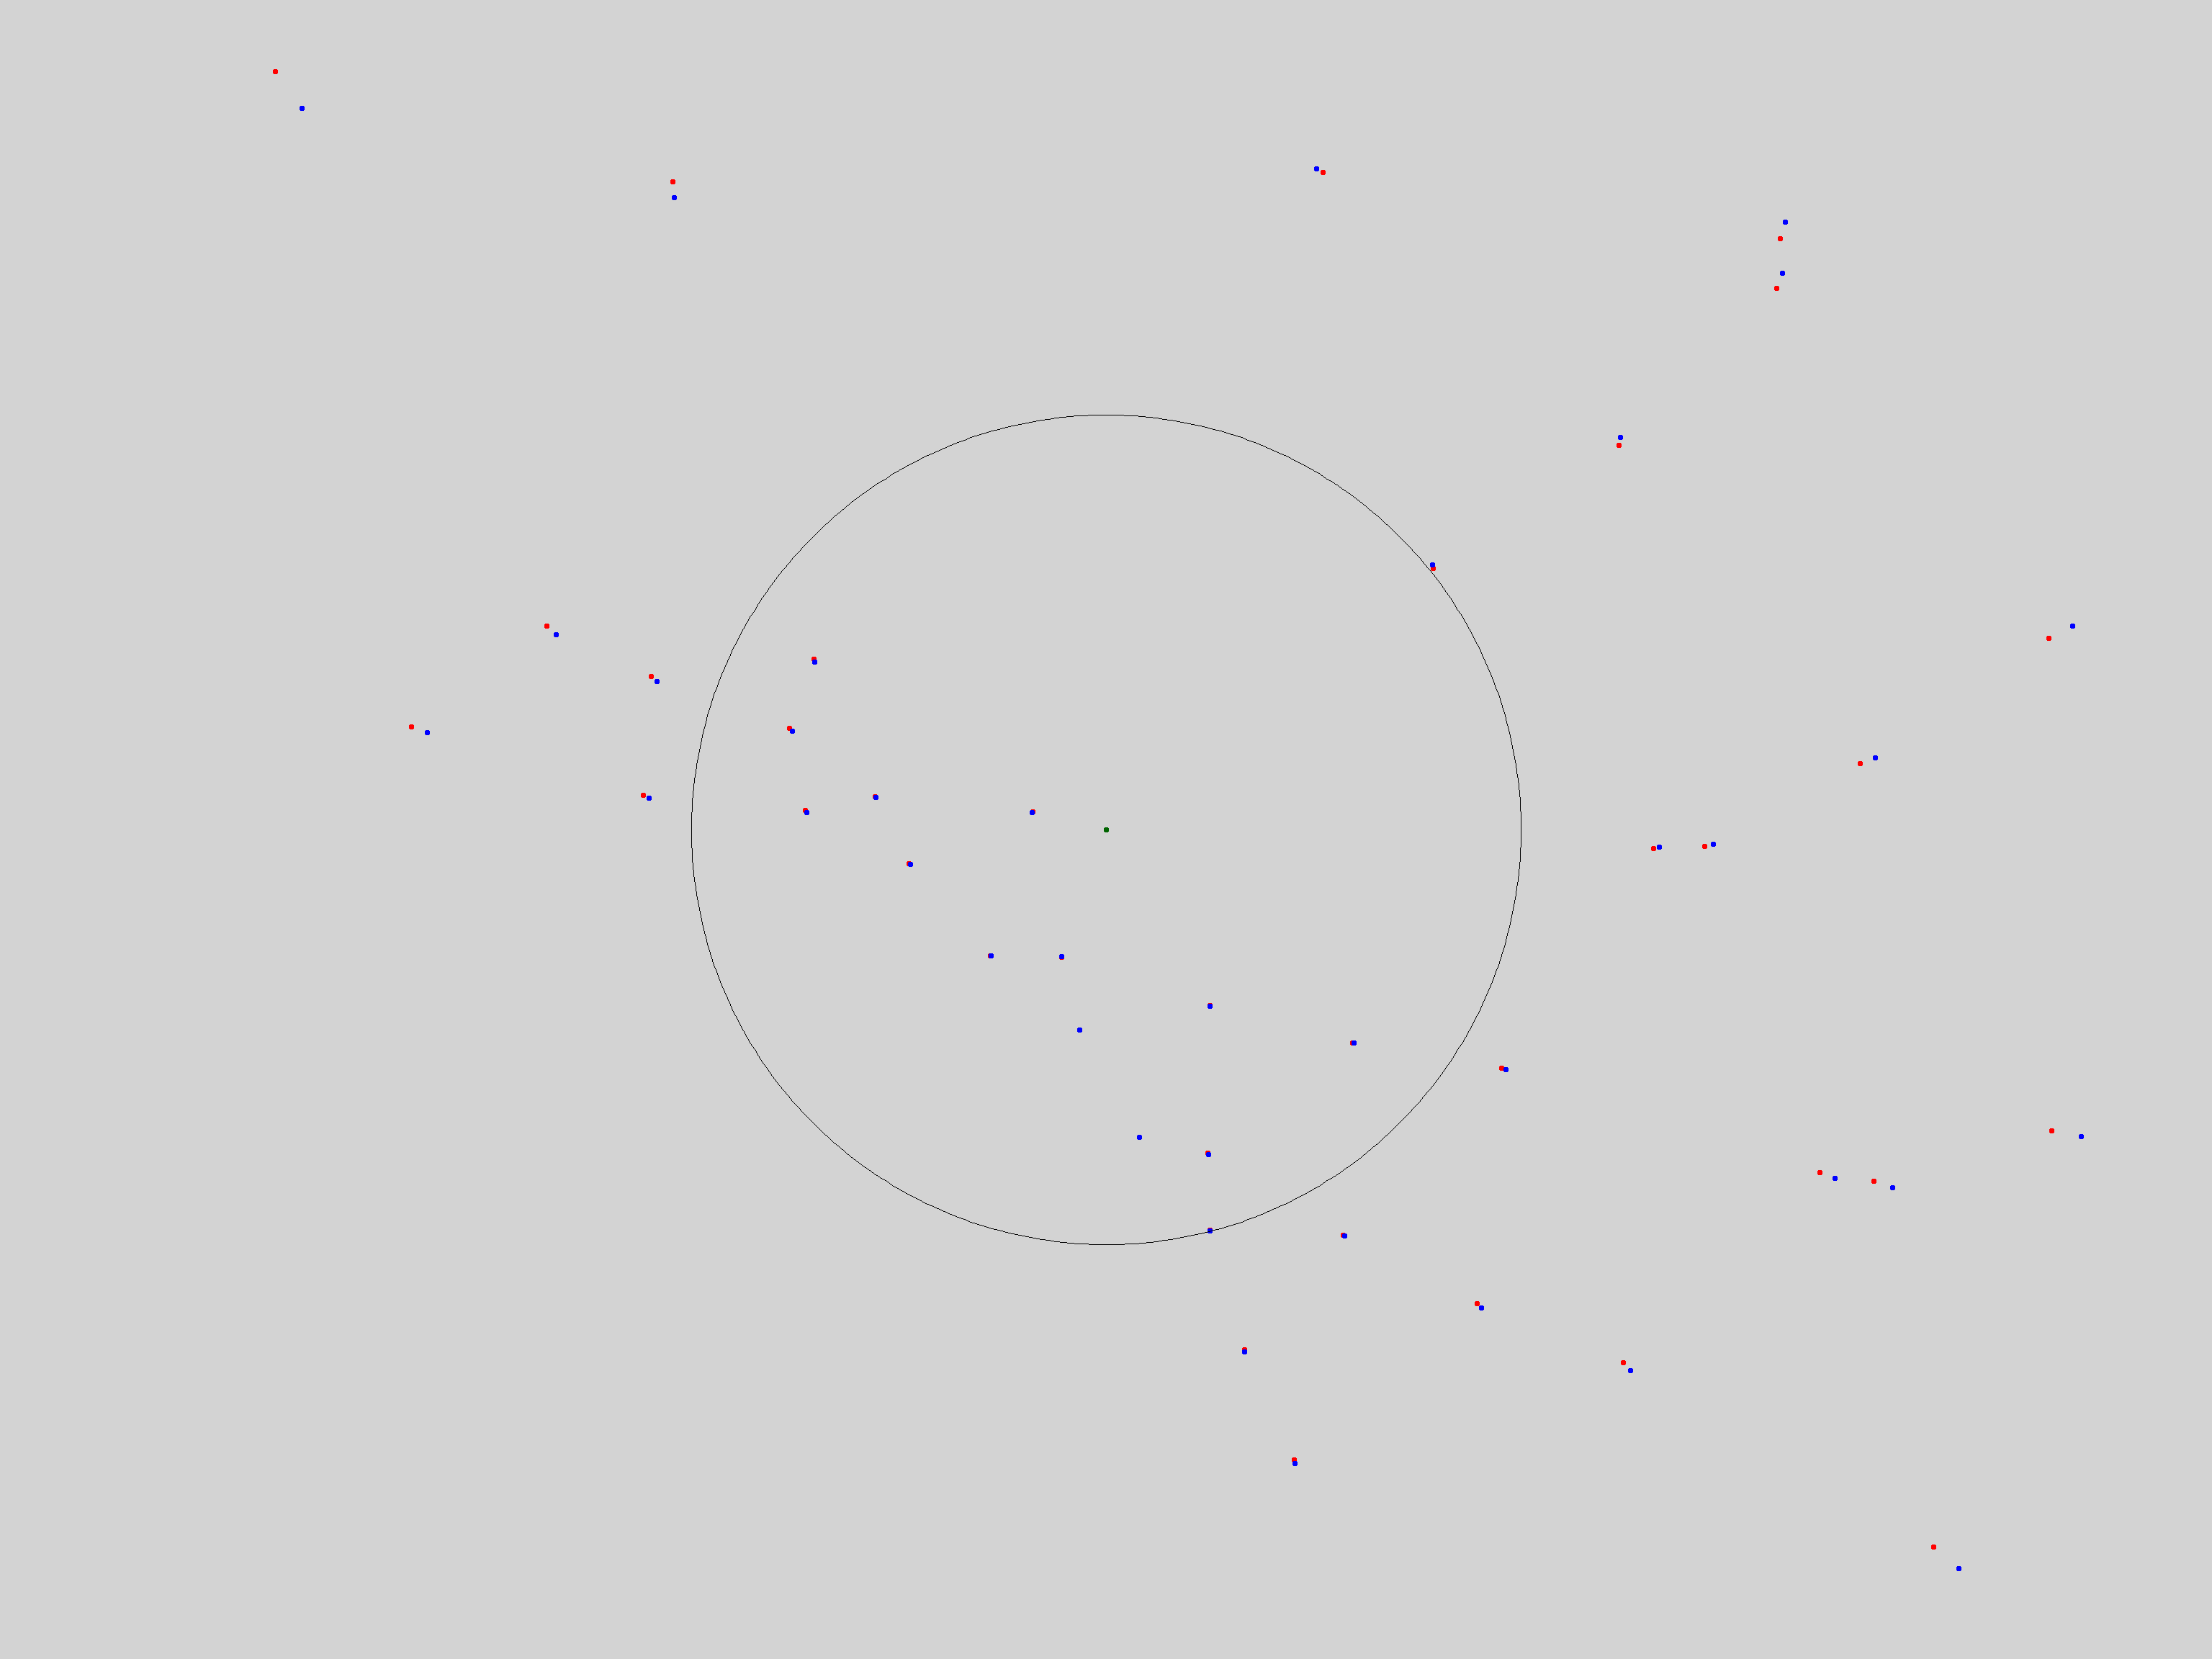

In [23]:
scatter_img

In [24]:
print "Script running time:", time() - start_time

Script running time: 4.08659219742


In [25]:
fname_scatter = res_folder

if center_only:
    fname_scatter += 'center_only_CenRad' + str(CENTER_RAD) + '_'

if consider_distort:
    scatter_img.save(fname_scatter + date[:-4] + '_shots' + str(num_shots) \
                     + '_scat_dis' + ".jpg")
else:
    scatter_img.save(fname_scatter + date[:-4] + '_shots' +  str(num_shots) \
                     + '_scat_aff' + ".jpg")